In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from scipy import stats

import joblib

import warnings
warnings.filterwarnings('ignore')

## Importing Data

In [2]:
df = pd.read_csv('data/car_price_prediction.csv')

## First Glance To Data

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19237 entries, 0 to 19236
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                19237 non-null  int64  
 1   Price             19237 non-null  int64  
 2   Levy              19237 non-null  object 
 3   Manufacturer      19237 non-null  object 
 4   Model             19237 non-null  object 
 5   Prod. year        19237 non-null  int64  
 6   Category          19237 non-null  object 
 7   Leather interior  19237 non-null  object 
 8   Fuel type         19237 non-null  object 
 9   Engine volume     19237 non-null  object 
 10  Mileage           19237 non-null  object 
 11  Cylinders         19237 non-null  float64
 12  Gear box type     19237 non-null  object 
 13  Drive wheels      19237 non-null  object 
 14  Doors             19237 non-null  object 
 15  Wheel             19237 non-null  object 
 16  Color             19237 non-null  object

In [5]:
desc = ['Price','Levy','Mileage' ,'Prod. year', 'Cylinders', 'Airbags']
df[desc].describe()

,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,4.582991,6.582627
std,1.905813e+05,5.668673,1.199933,4.320168
min,1.000000e+00,1939.000000,1.000000,0.000000
25%,5.331000e+03,2009.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,4.000000,6.000000
75%,2.207500e+04,2015.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,16.000000,16.000000


> The data we imported has **19237 rows** and ***18 columns***. Seems like we don't have any null value from ***info()*** method but actually in ***Levy*** column the ***null*** values entered as ***'-'*** so we had to change them to null values. We will handle this problem soon. 

> The descriptive statistics shows that the ***Prices, Levy, Mileage, Cylinders and Airbags*** probably have ***right skewed*** distribution because the means of these attributes are bigger than the medians. On the other hand, ***Prod. year*** looks like ***left skewed*** distribution.

## Exploratory Data Analysis and Data Cleaning

Let's start checking the unique values for each attributes

In [6]:
for col in df.columns:
    print(col)
    print(df[f'{col}'].unique())
    print('*'*75)

ID
[45654403 44731507 45774419 ... 45804997 45793526 45813273]
***************************************************************************
Price
[13328 16621  8467 ... 56814 63886 22075]
***************************************************************************
Levy
['1399' '1018' '-' '862' '446' '891' '761' '751' '394' '1053' '1055'
 '1079' '810' '2386' '1850' '531' '586' '1249' '2455' '583' '1537' '1288'
 '915' '1750' '707' '1077' '1486' '1091' '650' '382' '1436' '1194' '503'
 '1017' '1104' '639' '629' '919' '781' '530' '640' '765' '777' '779' '934'
 '769' '645' '1185' '1324' '830' '1187' '1111' '760' '642' '1604' '1095'
 '966' '473' '1138' '1811' '988' '917' '1156' '687' '11714' '836' '1347'
 '2866' '1646' '259' '609' '697' '585' '475' '690' '308' '1823' '1361'
 '1273' '924' '584' '2078' '831' '1172' '893' '1872' '1885' '1266' '447'
 '2148' '1730' '730' '289' '502' '333' '1325' '247' '879' '1342' '1327'
 '1598' '1514' '1058' '738' '1935' '481' '1522' '1282' '456' '880' '900'
 '798'

In [7]:
df[df['Levy'] == '-']

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
9,45756839,26657,-,LEXUS,RX 350,2007,Jeep,Yes,Petrol,3.5,128500 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
11,45814819,8781,-,FORD,Transit,1999,Microbus,No,CNG,4,0 km,8.0,Manual,Rear,02-Mar,Left wheel,Blue,0
12,45815568,3000,-,OPEL,Vectra,1997,Goods wagon,No,CNG,1.6,350000 km,4.0,Manual,Front,04-May,Left wheel,White,4
23,45814106,7840,-,FORD,Transit,2001,Microbus,No,Diesel,2.0 Turbo,230000 km,4.0,Manual,Front,02-Mar,Left wheel,White,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19223,44571028,8781,-,DODGE,Caliber,2008,Hatchback,No,Petrol,2.4,0 km,4.0,Automatic,Front,04-May,Left wheel,Blue,4
19224,45768089,19130,-,KIA,Optima ex,2014,Sedan,Yes,Petrol,2.4,35800 km,4.0,Automatic,Front,04-May,Left wheel,Black,12
19226,45796788,7840,-,NISSAN,Skyline,2003,Sedan,Yes,Petrol,3,220000 km,6.0,Tiptronic,Rear,04-May,Right-hand drive,White,0
19229,39977395,50,-,TOYOTA,Prius,2008,Hatchback,No,Hybrid,1.5,150000 km,4.0,Automatic,Front,04-May,Left wheel,Silver,6


> As I mentioned earlier we had the '-' values in the Levy column which used instead of null values. We have ***5819*** of them! We will replace them with null for now and will handle what to imput there later on.

In [8]:
# Replacing '-' with null
df['Levy'].replace({'-':np.nan}, inplace = True)
# Converting Levy type to float
df['Levy'] = df['Levy'].astype('float64')

In [9]:
# Replacement: Yes >> True , No >> False
df['Leather interior'].replace({'Yes': True, 'No':False}, inplace=True)

> We want to convert the Engine column type to float in order to do that we need to strip the ***'turbo'*** word in them. Also, we will make ***new column*** which is ***Turbo*** , will indicate that if the car has turbo or not (True and False).

In [10]:
# Making sure that we don miss anything so making everything lower first
df['Engine volume'] = df['Engine volume'].str.lower()

# Finding the rows which has turbo in them and assigning the results to new column Turbo. 
df['Turbo'] = df['Engine volume'].str.contains('turbo')

# Slicing engine volumes and converting type to float
df['Engine volume'] = df['Engine volume'].str.slice(0,3)
df['Engine volume'] = df['Engine volume'].astype('float64')

> The similar issue with ***Mileage*** as well in order to convert the type of this column to ***integer***, we need to strip ***'km'*** in them. So let's make it.

In [11]:
df['Mileage'] = df['Mileage'].str.strip('km')
df['Mileage'] = df['Mileage'].astype('int64')

> The ***'Doors'*** column has these unique values ***'04-May', '02-Mar', '>5'*** so respectively we will replace them to ***4, 2 and 5***.

In [12]:
df['Doors'].replace({'04-May':4, '02-Mar':2, '>5':5}, inplace=True)

Dropping the ID column which will not provide any information for our model

In [13]:
cars = df.drop('ID', axis=1)

Let's check the last version of our dataset after our cleaning.

In [66]:
cars.to_csv('data/cleaned_data.csv', index=False)

In [71]:
cars.groupby('Manufacturer')['Model'].nunique()

Manufacturer
ACURA            6
ALFA ROMEO       4
ASTON MARTIN     1
AUDI            39
BENTLEY          2
                ..
VAZ             11
VOLKSWAGEN      74
VOLVO           12
ZAZ              2
სხვა             2
Name: Model, Length: 65, dtype: int64

In [14]:
cars.head()

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
0,13328,1399.0,LEXUS,RX 450,2010,Jeep,True,Hybrid,3.5,186005,6.0,Automatic,4x4,4,Left wheel,Silver,12,False
1,16621,1018.0,CHEVROLET,Equinox,2011,Jeep,False,Petrol,3.0,192000,6.0,Tiptronic,4x4,4,Left wheel,Black,8,False
2,8467,NaN,HONDA,FIT,2006,Hatchback,False,Petrol,1.3,200000,4.0,Variator,Front,4,Right-hand drive,Black,2,False
3,3607,862.0,FORD,Escape,2011,Jeep,True,Hybrid,2.5,168966,4.0,Automatic,4x4,4,Left wheel,White,0,False
4,11726,446.0,HONDA,FIT,2014,Hatchback,True,Petrol,1.3,91901,4.0,Automatic,Front,4,Left wheel,Silver,4,False


> There are some values they are surreal to be true in the columns such as ***Mileage*** and ***Price***. So let's check them and then we will make outlier detection to get rid of some of these values.

In [15]:
display(cars[cars.Price == cars.Price.max()])
display(cars[cars.Price < 1000])

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
16983,26307500,NaN,OPEL,Combo,1999,Goods wagon,False,Diesel,1.7,99999,4.0,Manual,Front,2,Left wheel,Blue,0,False


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
7,549,751.0,HYUNDAI,Sonata,2013,Sedan,True,Petrol,2.4,216118,4.0,Automatic,Front,4,Left wheel,Grey,12,False
10,941,1053.0,MERCEDES-BENZ,E 350,2014,Sedan,True,Diesel,3.5,184467,6.0,Automatic,Rear,4,Left wheel,White,12,False
15,549,1079.0,TOYOTA,CHR,2018,Jeep,True,Petrol,2.0,74146,4.0,Automatic,Front,4,Left wheel,White,12,False
18,549,2386.0,HYUNDAI,Sonata,2006,Sedan,True,Petrol,3.3,295059,6.0,Automatic,Rear,4,Left wheel,Blue,12,False
19,941,1850.0,LEXUS,RX 400,2008,Jeep,True,Hybrid,3.5,364523,6.0,Automatic,4x4,4,Left wheel,Black,12,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19218,30,NaN,NISSAN,Note,2006,Hatchback,False,Petrol,1.3,0,4.0,Automatic,Front,4,Right-hand drive,Green,9,False
19228,706,1850.0,MERCEDES-BENZ,E 350,2008,Sedan,True,Diesel,3.5,122874,6.0,Automatic,Rear,4,Left wheel,Black,12,False
19229,50,NaN,TOYOTA,Prius,2008,Hatchback,False,Hybrid,1.5,150000,4.0,Automatic,Front,4,Left wheel,Silver,6,False
19230,470,645.0,TOYOTA,Prius,2011,Hatchback,True,Hybrid,1.8,307325,4.0,Automatic,Front,4,Left wheel,Silver,12,False


In [16]:
display(cars[cars.Mileage == cars.Mileage.max()])
display(cars[cars.Mileage < 1000])

,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
2278,6899,NaN,VOLKSWAGEN,Golf,1999,Sedan,False,Petrol,1.6,2147483647,4.0,Manual,Front,4,Left wheel,Black,4,False
6157,5959,NaN,MERCEDES-BENZ,C 180,1995,Sedan,False,CNG,1.8,2147483647,4.0,Manual,Rear,4,Left wheel,Blue,5,False
11901,10036,NaN,SUBARU,Forester,2005,Jeep,False,Petrol,2.0,2147483647,4.0,Tiptronic,4x4,4,Right-hand drive,White,12,False
12734,2200,NaN,UAZ,31514,1968,Jeep,True,CNG,2.4,2147483647,4.0,Manual,4x4,4,Left wheel,Black,10,False
15347,3,NaN,BMW,525,1995,Sedan,False,Petrol,2.8,2147483647,6.0,Manual,Rear,4,Left wheel,Black,3,False
15393,15681,NaN,TOYOTA,Prius,2008,Sedan,False,Petrol,2.0,2147483647,4.0,Automatic,Front,4,Left wheel,Blue,0,False
19167,18817,1995.0,FORD,Transit,2003,Microbus,False,Diesel,2.4,2147483647,4.0,Manual,Front,2,Left wheel,White,2,True


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Turbo
11,8781,NaN,FORD,Transit,1999,Microbus,False,CNG,4.0,0,8.0,Manual,Rear,2,Left wheel,Blue,0,False
24,4704,NaN,OPEL,Vectra,1995,Sedan,False,Petrol,1.8,0,4.0,Automatic,Front,4,Left wheel,Green,4,False
26,549,2455.0,LEXUS,GX 470,2008,Jeep,True,Petrol,4.7,0,8.0,Automatic,4x4,4,Left wheel,White,0,False
83,8154,NaN,HONDA,Cr-v,1998,Jeep,False,Petrol,2.0,0,4.0,Automatic,4x4,4,Right-hand drive,White,2,False
97,4234,NaN,HONDA,Civic,1997,Hatchback,True,Petrol,1.4,0,4.0,Manual,Front,2,Left wheel,Blue,6,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19064,2900,NaN,BMW,320,1994,Sedan,True,Petrol,2.0,0,6.0,Manual,Rear,4,Left wheel,Green,2,False
19088,2200,NaN,PEUGEOT,406,2001,Sedan,False,Petrol,2.0,0,4.0,Manual,Front,4,Left wheel,White,2,False
19103,30,NaN,NISSAN,Tiida,2006,Hatchback,False,Petrol,1.5,0,4.0,Automatic,Front,4,Right-hand drive,Black,4,False
19218,30,NaN,NISSAN,Note,2006,Hatchback,False,Petrol,1.3,0,4.0,Automatic,Front,4,Right-hand drive,Green,9,False


As a outlier detection algorithm, we will use ***IQR calculation*** and get rid of the values which is higher or lower than ***1.5 IQR***.

In [17]:
def detect_outliers(df,features,thold):
    outlier_indices = []
    
    for c in features:
        # 1st quartile
        Q1 = np.percentile(df[c],25)
        # 3rd quartile
        Q3 = np.percentile(df[c],75)
        # IQR
        IQR = Q3 - Q1
        # Outlier step
        outlier_step = IQR * thold
        # Detect outlier and their indices
        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        # Store indices
        outlier_indices.extend(outlier_list_col)
    
    
    return outlier_indices

In [18]:
features = ['Price', 'Levy', 'Mileage']
outliers = detect_outliers(cars,features, 1.5)
deleted_df = cars.drop(cars.loc[outliers].index,axis=0)

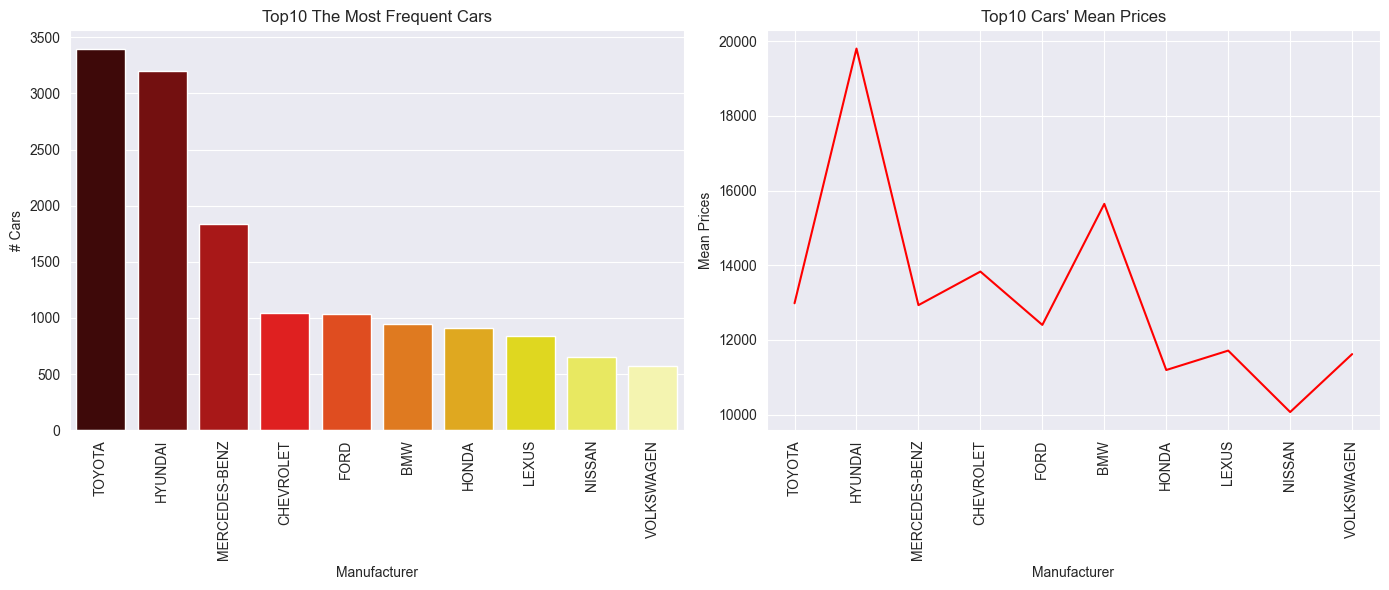

In [20]:
top10_cars = deleted_df['Manufacturer'].value_counts().sort_values(ascending=False)[:10]
top10_mean_prices = [deleted_df[deleted_df['Manufacturer'] == i]['Price'].mean() for i in list(top10_cars.index)]

fig = plt.figure(figsize=(14, 6))

# First subplot for the barplot
ax = fig.add_subplot(121)
sns.barplot(x=top10_cars.index, y=top10_cars.values, palette='hot', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('# Cars')
ax.set_title('Top10 The Most Frequent Cars')

# Second subplot for the lineplot
ax2 = fig.add_subplot(122)
sns.lineplot(x=top10_cars.index, y=top10_mean_prices, color='r', ax=ax2)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_ylabel('Mean Prices')
ax2.set_title("Top10 Cars' Mean Prices")

plt.tight_layout()
plt.show()


In [21]:
deleted_df.groupby('Doors')['Drive wheels'].value_counts()

Doors  Drive wheels
2      Rear              335
       Front             285
       4x4               103
4      Front           11528
       4x4              3440
       Rear             1723
5      Front              54
       Rear               30
       4x4                29
Name: count, dtype: int64

In [22]:
dd_val = np.array(deleted_df.groupby('Doors')['Drive wheels'].value_counts().values).reshape(3,3)
dd_sum = dd_val.sum(axis=1).reshape(3,1)
dd_sum = np.c_[dd_sum, dd_sum, dd_sum].flatten()

(deleted_df.groupby('Doors')['Drive wheels'].value_counts() / dd_sum)*100

Doors  Drive wheels
2      Rear            46.334716
       Front           39.419087
       4x4             14.246196
4      Front           69.067162
       4x4             20.609910
       Rear            10.322929
5      Front           47.787611
       Rear            26.548673
       4x4             25.663717
Name: count, dtype: float64

In [23]:
deleted_df.groupby('Drive wheels')['Price'].mean().sort_values(ascending=False)

Drive wheels
Front    14700.483441
Rear     13662.755268
4x4      12958.593505
Name: Price, dtype: float64

In [24]:
deleted_df.groupby('Gear box type')['Price'].median().sort_values(ascending=False)

Gear box type
Tiptronic    17876.0
Variator     13172.0
Automatic    11563.0
Manual        8781.0
Name: Price, dtype: float64

In [25]:
deleted_df.groupby('Color')['Price'].mean().sort_values(ascending=False)

Color
Yellow           16165.645833
Grey             15511.388683
White            14855.971142
Brown            14810.414201
Carnelian red    14742.733728
Orange           14695.240506
Beige            14418.140625
Black            14270.543848
Sky blue         13961.554622
Silver           13956.965266
Golden           13623.264286
Blue             12751.590000
Red              12338.672078
Green             9117.311475
Pink              8967.560000
Purple            8837.384615
Name: Price, dtype: float64

In [26]:
deleted_df.groupby('Turbo')['Price'].median().sort_values(ascending=False)

Turbo
True     18189.0
False    11917.0
Name: Price, dtype: float64

In [27]:
deleted_df.groupby('Wheel')['Price'].median().sort_values(ascending=False)

Wheel
Left wheel          13485.0
Right-hand drive     8467.0
Name: Price, dtype: float64

In [28]:
deleted_df.groupby('Fuel type')['Price'].median().sort_values(ascending=False)

Fuel type
Plug-in Hybrid    22580.0
Hydrogen          20385.0
Diesel            18817.0
LPG               13485.0
Petrol            11917.0
Hybrid            10036.0
CNG                7527.0
Name: Price, dtype: float64

In [29]:
deleted_df['Fuel type'].value_counts()

Fuel type
Petrol            9362
Diesel            3596
Hybrid            3383
LPG                632
CNG                469
Plug-in Hybrid      84
Hydrogen             1
Name: count, dtype: int64

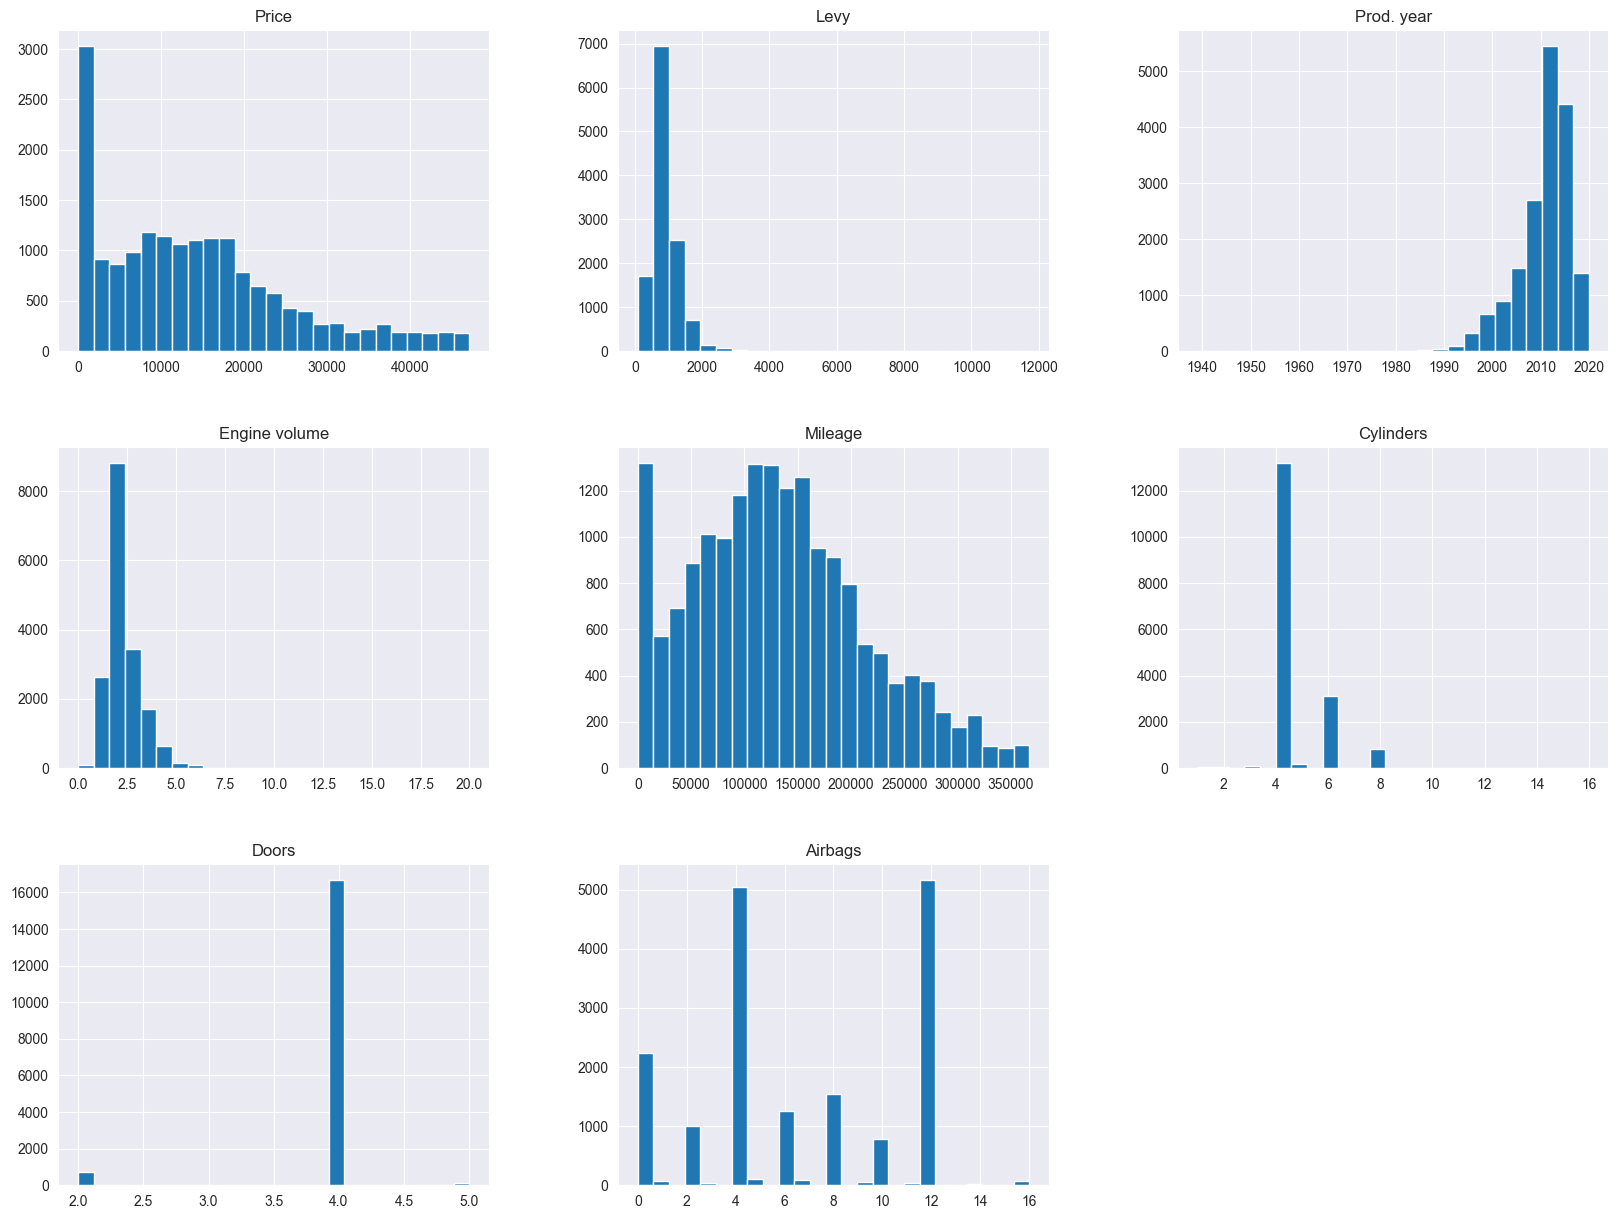

In [30]:
%matplotlib inline

deleted_df.hist(bins=25, figsize=(20,15))
plt.show()

As we said at very first from describe method, Price, Mileage, Levy has right skewed distribution and Prod. Year has left skewed distribution.

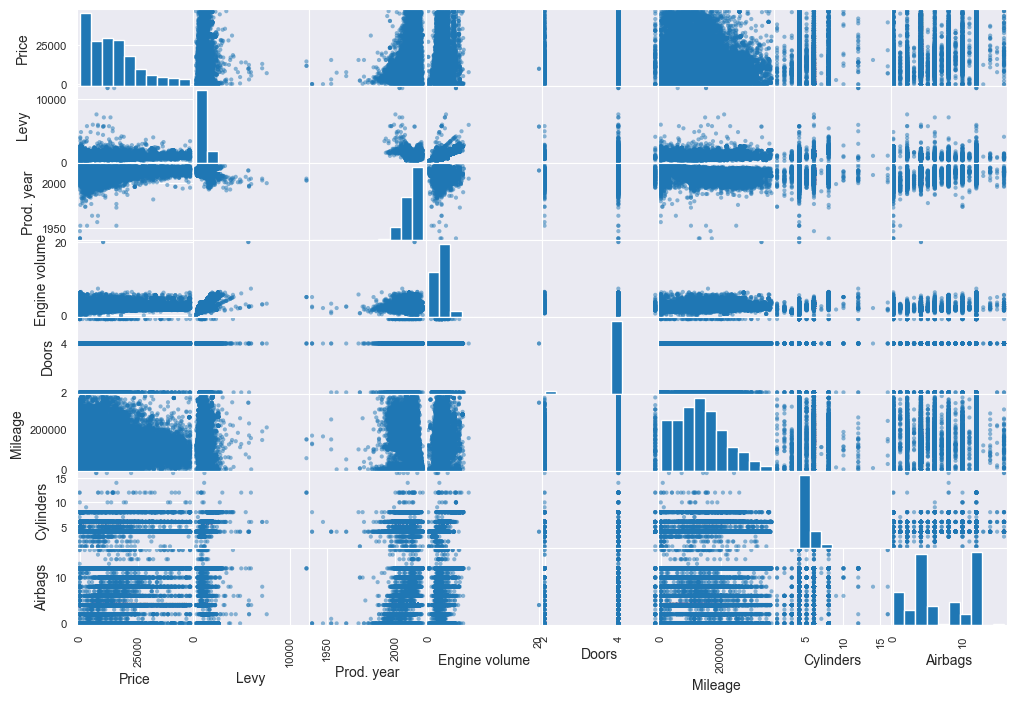

In [37]:
attributes = ['Price','Levy','Prod. year', 'Engine volume','Doors', 'Mileage', 'Cylinders', 'Airbags']

scatter_matrix(deleted_df[attributes], figsize=(12,8))
plt.show()

> There ***positive correlation*** between ***Engine volume and Levy*** and ***slightly negative correlation*** between ***Levy and Prod. year***. Let's check the actual correlation scores between those attributes.

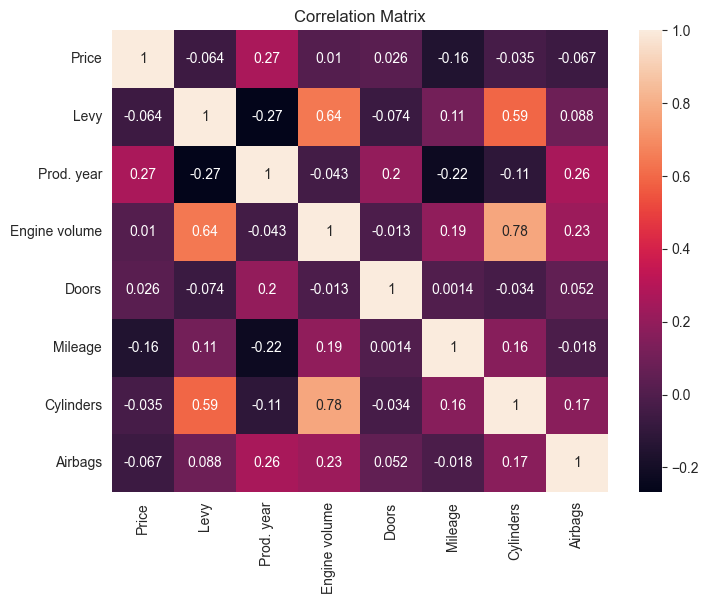

In [38]:
plt.figure(figsize=(8,6))
sns.heatmap(deleted_df[attributes].corr(),annot=True, cbar = True)
plt.title('Correlation Matrix')
plt.show()

>The assumptions we made from scatter plot seems quite correct! The correliation between Levy and Engine volume ***0.64*** (not bad!). Engine volume and Cylinders has quite strong relationship which is ***0.78*** not that suprising that the cars have more cylinders have more engine volume and Levy.

In [80]:
num_attribs = ['Levy','Prod. year', 'Engine volume','Doors', 'Mileage', 'Cylinders', 'Airbags']
cat_attribs = ['Manufacturer','Category', 'Leather interior', 'Fuel type', 'Gear box type', 'Drive wheels', 'Wheel', 'Color', 'Turbo']

Let's split our target value from our dataset.

In [81]:
num_cars = deleted_df[num_attribs]
y = deleted_df['Price']
cat_cars = deleted_df[cat_attribs]

At very first stage we replaced ***'-'*** with ***NaN***s which was for ***Levy*** column. Time to handle with them. We will impute ***median*** values for that NaNs.(We don't have any other NaN value in another column so the following code just will impute them into the Levy but if your dataset has NaN's in the multiple column the code we will type will impute medians to each column seperately.)

In [82]:
Imputer = SimpleImputer(strategy='median')

Imputer.fit(num_cars)
# Displaying medians of every numeric column we have
display(Imputer.statistics_)
num_cars = Imputer.transform(num_cars)

array([7.79000e+02, 2.01200e+03, 2.00000e+00, 4.00000e+00, 1.26265e+05,
       4.00000e+00, 6.00000e+00])

Time to scale our numerical attributes! Scaling will help to our model to make better predictions and computation time will be less.

In [83]:
num_cars

array([[1.39900e+03, 2.01000e+03, 3.50000e+00, ..., 1.86005e+05,
        6.00000e+00, 1.20000e+01],
       [1.01800e+03, 2.01100e+03, 3.00000e+00, ..., 1.92000e+05,
        6.00000e+00, 8.00000e+00],
       [7.79000e+02, 2.00600e+03, 1.30000e+00, ..., 2.00000e+05,
        4.00000e+00, 2.00000e+00],
       ...,
       [8.36000e+02, 2.01000e+03, 2.00000e+00, ..., 1.16365e+05,
        4.00000e+00, 4.00000e+00],
       [1.28800e+03, 2.00700e+03, 2.00000e+00, ..., 5.12580e+04,
        4.00000e+00, 4.00000e+00],
       [7.53000e+02, 2.01200e+03, 2.40000e+00, ..., 1.86923e+05,
        4.00000e+00, 1.20000e+01]])

In [74]:
scaler = StandardScaler()
num_cars = scaler.fit_transform(num_cars)

In [43]:
num_cars

array([[ 1.37160845, -0.1217927 ,  1.41203665, ...,  0.65905288,
         1.24261819,  1.24708939],
       [ 0.40211876,  0.05745498,  0.83329684, ...,  0.73275   ,
         1.24261819,  0.32314571],
       [-0.20603881, -0.8387834 , -1.13441853, ...,  0.83109479,
        -0.47689618, -1.06276982],
       ...,
       [-0.06099705, -0.1217927 , -0.32418279, ..., -0.19703846,
        -0.47689618, -0.60079798],
       [ 1.0891587 , -0.65953572, -0.32418279, ..., -0.99740519,
        -0.47689618, -0.60079798],
       [-0.27219821,  0.23670266,  0.13880906, ...,  0.67033795,
        -0.47689618,  1.24708939]])

Let's put these 2 steps together to use them with one piece of code when we need them in the future.

In [75]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler())])

Also we need to handle with the categorical columns because the machine learning model we will use expects only numerical values. So we will use one hot encoding, which will give 1 (Hot) the attribute is exist for that sample and 0 (Cold) for others and making full pipeline which will handle numerical values and categorical values at the same time)

In [76]:
full_pipeline = ColumnTransformer([
    ('num',num_pipeline, num_attribs),
    ('cat',OneHotEncoder(), cat_attribs)  
])
cars_prepared = full_pipeline.fit_transform(deleted_df)

Time to split our data for train and test, we will use %66 of them for train and %33 of them for test step.

In [79]:
cars_prepared

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 280432 stored elements and shape (17527, 114)>

In [46]:
X_train, X_test, y_train, y_test = train_test_split(cars_prepared, y, test_size=0.33, random_state = 123)

## Model Setup, Hyperparameter Tuning and Model Evaluation

This is a regression type problem so very first thing I want to try is Linear Regression, ofc!

In [47]:
lin_reg = LinearRegression()

lin_reg.fit(X_train, y_train)

LinearRegression()

In [48]:
predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

np.float64(9216.57132440252)

We are approximately 9.2k away from actual prices which is not bad let's check MAE as well.

In [49]:
mae = mean_absolute_error(y_train, predictions)
mae

np.float64(7129.707920888405)

The next algorithm I wanna try is decision tree, let's check how good it is with that problem.

In [50]:
tree_reg = DecisionTreeRegressor(random_state = 123)

tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(random_state=123)

In [51]:
tree_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

np.float64(995.1400359363548)

Just 995??! Decision tree is really keen on to overfitting so just checking rmse will not be enough to evaluate it let's check cross validation score for it.

In [52]:
scores = cross_val_score(tree_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)

tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([7454.58364456, 7298.07276603, 7704.87808287, 7407.14703388,
       7713.85297711])

OK, the results seems more reasonable now. Our model is doing better than linear regression model.

In [53]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)
lin_rmse_scores

array([8999.20203447, 9584.72175793, 9347.38251843, 9092.60224074,
       9528.09685031])

Another algorithm we will try is Random Forest which is ensemble model. This model relies on randomness, means that n_estimator times decision tree will be trained and the results will combined. (This model will take more time to train than others we tried before as you guess.)

In [54]:
forest_reg = RandomForestRegressor(n_estimators = 100, random_state=123)

forest_reg.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

In [55]:
forest_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

np.float64(2297.021106042258)

In [56]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=5)
forest_rmse_scores = np.sqrt(-forest_scores)
forest_rmse_scores

array([5780.25626157, 5684.29515446, 5546.55824399, 5652.49716654,
       6005.14956653])

> Random Forest superiors other 2 algorithm so far so let's continue with this algorithm and tune the hyperparameters for it using GridSearchCV. This step will take 10-20 minutes depending on your computer so be careful before running this cell on your pc)

In [57]:
param_grid = [
    {'n_estimators': [100, 200], 'max_features': [35,33,31]},
  ]

forest_reg = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [35, 33, 31],
                          'n_estimators': [100, 200]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [58]:
grid_search.best_params_

{'max_features': 35, 'n_estimators': 200}

In [59]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

5605.153105055072 {'max_features': 35, 'n_estimators': 100}
5589.300388047561 {'max_features': 35, 'n_estimators': 200}
5606.944440610192 {'max_features': 33, 'n_estimators': 100}
5593.997639552287 {'max_features': 33, 'n_estimators': 200}
5608.1611045576665 {'max_features': 31, 'n_estimators': 100}
5602.688100289354 {'max_features': 31, 'n_estimators': 200}


In [60]:
feature_importances = grid_search.best_estimator_.feature_importances_
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = [i  for cat in cat_encoder.categories_ for i in cat]
attributes = num_attribs +  cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(np.float64(0.16222821803285245), 'Prod. year'),
 (np.float64(0.11406447328306066), 'Mileage'),
 (np.float64(0.10666123617296097), 'Airbags'),
 (np.float64(0.06947240110283213), 'Levy'),
 (np.float64(0.061376914505837266), 'Engine volume'),
 (np.float64(0.060392968321859065), 'Diesel'),
 (np.float64(0.036292755395727495), 'Tiptronic'),
 (np.float64(0.02880576099864349), 'HYUNDAI'),
 (np.float64(0.02447151552525159), 'Automatic'),
 (np.float64(0.023294992090805034), 'SSANGYONG'),
 (np.float64(0.019544986498590513), 'Cylinders'),
 (np.float64(0.019094152758166442), 'Sedan'),
 (np.float64(0.01711112825196807), 'Jeep'),
 (np.float64(0.015229080814674518), np.False_),
 (np.float64(0.01482844293802825), np.True_),
 (np.float64(0.014237762684945338), 'Front'),
 (np.float64(0.012764262163777015), np.True_),
 (np.float64(0.012632612830036057), 'TOYOTA'),
 (np.float64(0.012417781667569999), np.False_),
 (np.float64(0.010904544507763732), 'Black'),
 (np.float64(0.009867545588716014), 'White'),
 

In [61]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

np.float64(5761.036495090154)

Sooo as a final result we are 5.7k far away from actual results, this is not bad! Also we seems like we don't have overfitting problem at all, means that our model generalizes well. Let's make confidence interval to serve our results.

In [62]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([5506.64790839, 6004.65750968])

We are 95 percent confident to say that our errors will be in the range of (5506.64790839 , 6004.65750968).

In [63]:
# Save the model we trained
joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

In [93]:
from sklearn.base import BaseEstimator, TransformerMixin

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class TopFeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    def transform(self, X):
        return X[:, self.feature_indices_]

In [94]:
final_pipeline = Pipeline([('full',full_pipeline),
                           ('top_feature_selector',TopFeatureSelector(feature_importances, 35)),
                          ('model', final_model)])

In [97]:
final_pipeline.fit(deleted_df.drop('Price', axis=1), deleted_df['Price'])

Pipeline(steps=[('full',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('std_scaler',
                                                                   StandardScaler())]),
                                                  ['Levy', 'Prod. year',
                                                   'Engine volume', 'Doors',
                                                   'Mileage', 'Cylinders',
                                                   'Airbags']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Manufacturer', 'Category',
                                                   'Leather interior',
                                                   'Fuel type', 'Gear box type',
                                                   'Drive wheels', 'Wheel',...
       6.89286962e-04, 1.09045445e-02, 4.91363900e-03, 1.22662595e-03,
       1.16353151e-03, 6.00773923e-04, 4.97234591e-04, 7.17224146e-03,
       5.55137979e-04, 3.22300378e-05, 5.26031154e-05, 1.98761021e-03,
       8.98243376e-03, 7.06118830e-04, 9.86754559e-03, 3.59591640e-04,
       1.24177817e-02, 1.27642622e-02]),
                                    k=35)),
                ('model',
                 RandomForestRegressor(max_features=35, n_estimators=200,
                                       random_state=42))])

In [105]:
some_data = deleted_df.drop('Price', axis=1).iloc[:4]
some_labels = deleted_df['Price'].iloc[:4]

pred = final_pipeline.predict(some_data)
display(pred)
display(some_labels.values)

array([13366.02646922, 16402.68      ,  8588.61      ,  3413.84898063])

array([13328, 16621,  8467,  3607])

In [121]:
custom_data = {
    'Manufacturer': ['TOYOTA'],
    'Model': ['Camry'],
    'Prod. year': [2015],
    'Category': ['Sedan'],
    'Leather interior': [True],
    'Fuel type': ['Petrol'],
    'Engine volume': [2.5],
    'Mileage': [80000],
    'Cylinders': [4],
    'Gear box type': ['Automatic'],
    'Drive wheels': ['Front'],
    'Doors': [4],
    'Wheel': ['Left wheel'],
    'Color': ['Silver'],
    'Airbags': [6],
    'Turbo': [False],
    'Levy': [100.0]
}

# Convert custom data to DataFrame
custom_df = pd.DataFrame(custom_data)
pred = final_pipeline.predict(custom_df)
display(pred)

array([25263.345])

In [122]:
# Save the entire pipeline
joblib.dump(final_pipeline, "final_pipeline.pkl")

# Load the entire pipeline
f_pipeline = joblib.load("final_pipeline.pkl")

# Predict with the loaded pipeline
pred = f_pipeline.predict(custom_df)
print(pred)


[25263.345]
